In [150]:
from sklego.preprocessing import OrthogonalTransformer
from scipy.linalg import orth

In [267]:
import numpy as np
import pandas as pd
from patsy import dmatrix, build_design_matrices, PatsyError
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array, check_X_y
from sklearn.utils.validation import FLOAT_DTYPES, check_random_state, check_is_fitted

from sklego.common import TrainOnlyTransformerMixin, as_list

def scaler_(vec, unto):
    return vec.dot(unto)/unto.dot(unto)


def project_(vec, unto):
    return scaler_(vec, unto) * unto


class InformationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = as_list(columns)

    def check_coltype_(self, X):
        for col in self.columns:
            if isinstance(col, str):
                if isinstance(X, np.ndarray):
                    raise ValueError(f"column {self.column} is a string but datatype receive is numpy.")
                if isinstance(X, pd.DataFrame):
                    if col not in X.columns:
                        raise ValueError(f"column {col} is not in {X.columns}")
            if isinstance(col, int):
                if col not in range(X.shape[1]):
                    raise ValueError(f"column {col} is out of bounds for input shape {X.shape}")

    def col_idx(self, X, name):
        if isinstance(name, str):
            if isinstance(X, np.ndarray):
                raise ValueError("You cannot have a column of type string on a numpy input matrix.")
            return {name: i for i, name in enumerate(X.columns)}[name]
        return name
    
    def _make_v_vectors(self, X, col_ids):
        vs = np.zeros((X.shape[0], len(col_ids)))
        for i, c in enumerate(col_ids):
            vs[:, i] = X[:, col_ids[i]]
            for j in range(0, i):
                vs[:, i] = vs[:, i] - project_(vs[:, i], vs[:, j])
        return vs
        
    def fit(self, X, y=None):
        self.check_coltype_(X)
        self.col_ids_ = [v if isinstance(v, int) else self.col_idx(X, v) for v in self.columns]
        X = check_array(X, estimator=self)
        X_fair = X.copy()
        v_vectors = _make_v_vectors(X, self.col_ids_)
#         print(self.col_ids_)
#         print("v_vectors", v_vectors, (v_vectors[:, 0] * v_vectors[:, 1]).sum())
        # gram smidt process but only on sensitive attributes 
        for i, col in enumerate(X_fair.T):
            for v in v_vectors.T:
                X_fair[:, i] = X_fair[:, i] - project_(X_fair[:, i], v)
        self.X_fair = X_fair
        # we want to learn matrix P: X P = X_fair
        # this means we first need to create X_fair in order to learn P
        self.projection_, resid, rank, s = np.linalg.lstsq(X, X_fair, rcond=None)
        return self

    def transform(self, X):
        check_is_fitted(self, ['projection_', 'col_ids_'])
        self.check_coltype_(X)
        X = check_array(X, estimator=self)
        # apply the projection and remove the column we won't need
        X_fair = X @ self.projection_
        return np.atleast_2d(np.delete(X_fair, self.col_ids_, axis=1))


In [268]:
import numpy as np
import pandas as pd 
from scipy.spatial.distance import cosine
import matplotlib.pylab as plt

from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression

def scaler_(vec, unto):
    return vec.dot(unto)/unto.dot(unto)

def project_(vec, unto):
    return scaler_(vec, unto) * unto

def orthogonal_(arr, away):
    return arr - project_(arr, away)

In [269]:
from sklego.preprocessing import OrthogonalTransformer

In [270]:
def simple_mod():
    return Pipeline([("scale", StandardScaler()), ("mod", LinearRegression())])

def bootstrapper(X, var, n=250, k=25):
    selector = df[var] > np.quantile(df[var], 0.5)
    mod = simple_mod().fit(X, y)
    mod_df = pd.DataFrame(X)
    res = []
    for i in range(n):
        s1 = mod.predict(mod_df[selector].sample(k))
        s2 = mod.predict(mod_df[~selector].sample(k))
        res.append(s1.mean() - s2.mean())
    return res, np.mean(res)

def bootstrap_plot(X, X_fair, sens_var, n=2000, k=50):
    mod_fair = simple_mod().fit(X_fair, y)
    mod_unfair = simple_mod().fit(X, y)
    
    samples, avg1 = bootstrapper(X, var=sens_var, n=n, k=k)
    height, bins, _ = plt.hist(samples, density=True, alpha=0.6, bins=30)
    plt.vlines(avg1, 0, height.max());
    
    samples, avg2 = bootstrapper(X_fair, var=sens_var, n=n, k=k)
    height, bins, _ = plt.hist(samples, density=True, alpha=0.6, bins=30)
    plt.vlines(avg2, 0, height.max())
    print(f"difference = {avg2 - avg1} -> {(avg2 - avg1)/np.abs(avg1)}");

In [271]:
def _make_v_vectors(X, col_ids):
    vs = np.zeros((X.shape[0], len(col_ids)))
    for i, c in enumerate(col_ids):
        vs[:, i] = X[:, col_ids[i]]
        for j in range(0, i):
            vs[:, i] = vs[:, i] - project_(vs[:, i], vs[:, j])
    return vs
        
_make_v_vectors(df.values, [12, 11, 0])

array([[ 4.98000000e+00,  2.96003193e+02,  1.32429233e+00],
       [ 9.14000000e+00,  2.11719917e+02, -9.77139591e-01],
       [ 4.03000000e+00,  3.11180576e+02,  1.83359844e+00],
       ...,
       [ 5.64000000e+00,  2.82631327e+02,  1.01027116e+00],
       [ 6.48000000e+00,  2.62162589e+02,  5.54527707e-01],
       [ 7.88000000e+00,  2.37248025e+02, -2.53613720e-01]])

In [272]:
v1 = df['lstat']
v2 = df['b'] - project_(df['b'], v1)
v3 = df['crim'] - project_(df['crim'], v1) - project_(df['crim'], v2)
np.array([v1, v2, v3]).T

array([[ 4.98000000e+00,  2.96003193e+02,  1.32429233e+00],
       [ 9.14000000e+00,  2.11719917e+02, -9.77139591e-01],
       [ 4.03000000e+00,  3.11180576e+02,  1.83359844e+00],
       ...,
       [ 5.64000000e+00,  2.82631327e+02,  1.01027116e+00],
       [ 6.48000000e+00,  2.62162589e+02,  5.54527707e-01],
       [ 7.88000000e+00,  2.37248025e+02, -2.53613720e-01]])

In [274]:
ifilter = InformationFilter(columns=["lstat", "b"])
X_fair = ifilter.fit_transform(df)

# [(c * df['lstat']).sum() for c in X_fair.T], [(c * df['b']).sum() for c in X_fair.T]
pd.DataFrame(ifilter.X_fair).head(3)

([-3.456079866737127e-11,
  8.276401786133647e-11,
  3.183231456205249e-10,
  -1.6626700016786344e-12,
  -1.5788259588589426e-11,
  2.864908310584724e-11,
  8.776623872108757e-11,
  8.412825991399586e-12,
  6.912159733474255e-11,
  4.0745362639427185e-10,
  4.729372449219227e-11],
 [-2.3283064365386963e-10,
  -2.6193447411060333e-09,
  1.021544449031353e-08,
  -2.3874235921539366e-11,
  -5.002220859751105e-12,
  3.2014213502407074e-10,
  5.4569682106375694e-09,
  -2.1827872842550278e-10,
  -2.3283064365386963e-10,
  -3.3527612686157227e-08,
  2.837623469531536e-10])

In [259]:
var = "lstat"

X, y = load_boston(return_X_y=True)
df = pd.DataFrame(X, columns=['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat'])

v1 = df['lstat']
v2 = df['b'] - project_(df['b'], v1)

X_fair = pd.DataFrame([df[c] - project_(df[c], v1) - project_(df[c], v2) for c in df.columns]).T.values
X_fair = pd.DataFrame(X_fair, columns=df.columns).drop(columns=['b', 'lstat'])

X_drop = df.drop(columns=var).values
df.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


In [248]:
X_fair.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio
0,1.324292,-1.341702,-3.503309,-0.079133,0.108253,0.529927,19.304354,-0.423321,-2.513147,32.027570,-0.630086
1,-0.977140,-15.820786,-1.593818,-0.077157,-0.036831,0.076198,19.939300,0.666608,-4.508858,-100.641522,0.079753
2,1.833598,-19.904196,1.932269,-0.078748,0.060101,1.266684,18.498212,0.454070,-0.829780,-2.265959,2.420103


In [249]:
[(X_fair[c] * df['lstat']).sum() for c in X_fair.columns]

[1.2732925824820995e-11,
 -1.2732925824820995e-11,
 3.1377567211166024e-11,
 5.684341886080802e-14,
 1.9895196601282805e-13,
 1.1482370609883219e-11,
 -1.5006662579253316e-11,
 6.252776074688882e-13,
 2.1827872842550278e-11,
 -5.820766091346741e-11,
 -4.547473508864641e-12]

In [250]:
[(X_fair[c] * df['b']).sum() for c in X_fair.columns]

[1.7462298274040222e-10,
 -4.0745362639427185e-10,
 2.9103830456733704e-10,
 -1.1368683772161603e-12,
 -2.0463630789890885e-11,
 1.800799509510398e-10,
 -3.1723175197839737e-09,
 -6.548361852765083e-11,
 1.7462298274040222e-10,
 -1.0244548320770264e-08,
 -2.2919266484677792e-10]

In [251]:
base_mod = simple_mod().fit(X, y)
drop_mod = simple_mod().fit(X_drop, y)
fair_mod = simple_mod().fit(X_fair, y)

base_pred = base_mod.predict(X)
drop_pred = drop_mod.predict(X_drop)
fair_pred = fair_mod.predict(X_fair)

selector = df[var] > np.quantile(df[var], 0.5)

In [126]:
pd.DataFrame([base_mod.steps[1][1].coef_, drop_mod.steps[1][1].coef_, fair_mod.steps[1][1].coef_], columns=df.columns)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,-0.928146,1.081569,0.140900,0.681740,-2.056718,2.674230,0.019466,-3.104044,2.662218,-2.076782,-2.060607,0.849268,-3.743627
1,-1.374364,0.905733,-0.191364,0.816182,-2.371357,4.297922,-1.291657,-3.270958,2.449323,-1.976397,-2.193566,1.242283,NaN
2,-0.763568,1.028051,0.061393,0.697504,-1.605464,6.846774,-0.057920,-2.537602,1.935058,-1.779825,-2.793069,NaN,NaN


In [112]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y, base_pred), mean_squared_error(y, drop_pred), mean_squared_error(y, fair_pred)

(21.894831181729202, 26.659334520325558, 65.61848671196229)

In [113]:
def bootstrap_means(preds, selector, n=2500, k=25):
    grp1 = np.random.choice(preds[selector], (n, k)).mean(axis=1)
    grp2 = np.random.choice(preds[~selector], (n, k)).mean(axis=1)
    return grp1 - grp2

# No Difference in Same Model

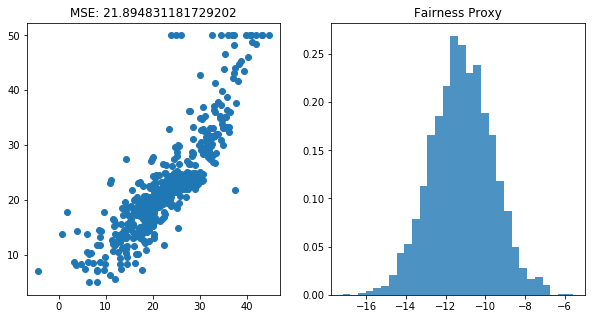

In [158]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(base_pred, y)
plt.title(f"MSE: {mean_squared_error(y, base_pred)}")
plt.subplot(122)
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8)
plt.title(f"Fairness Proxy");

# Difference by Dropping Column

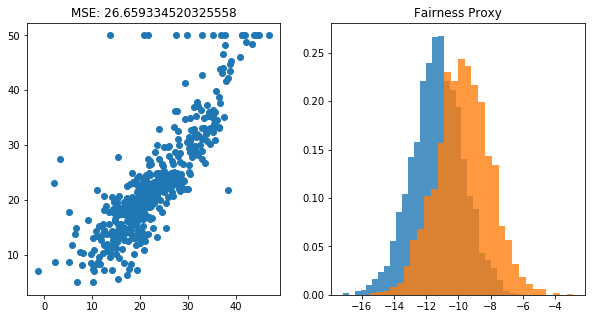

In [159]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(drop_pred, y)
plt.title(f"MSE: {mean_squared_error(y, drop_pred)}")
plt.subplot(122)
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8)
plt.hist(bootstrap_means(drop_pred, selector), bins=30, density=True, alpha=0.8)
plt.title(f"Fairness Proxy");

# Difference by Filtering Column

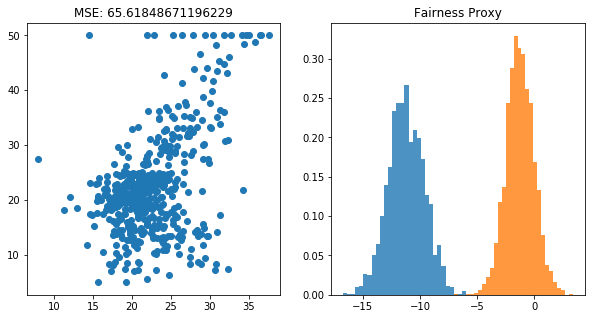

In [160]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(fair_pred, y)
plt.title(f"MSE: {mean_squared_error(y, fair_pred)}")
plt.subplot(122)
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8)
plt.hist(bootstrap_means(fair_pred, selector), bins=30, density=True, alpha=0.8)
plt.title(f"Fairness Proxy");

# Could we predict unfairness?

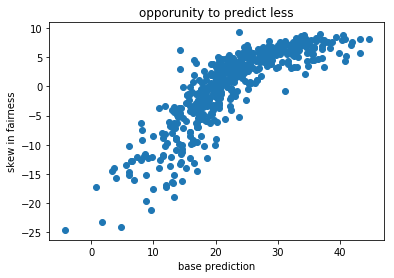

In [163]:
plt.scatter(base_pred, base_pred - fair_pred)
plt.xlabel("base prediction")
plt.ylabel("skew in fairness")
plt.title("opporunity to predict less");